# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science: 

## Homework 5: Logistic Regression, High Dimensionality and PCA, LDA/QDA


**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

Erik Johnsson, Nathan Goldberg

<hr style="height:2pt">

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

import math
from scipy.special import gamma

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

alpha = 0.5

## Cancer Classification from Gene Expressions

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The data set is provided in the file `dataset_hw5_1.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with 0 indicating the ALL class and 1 indicating the AML class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build a classification models for this data set. We will also use Principal Components Analysis (PCA) to visualize the data and to reduce its dimensions. 



## Question 1: Data Exploration

1. First step is to  split  the observations into an approximate 50-50 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits).

2. Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.

3. Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?

4. Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

5. Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

#### Answers:
**1.1:** First step is to split the observations into an approximate 50-50 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits).

In [2]:
np.random.seed(9002)
df = pd.read_csv('data/dataset_hw5_1.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [3]:
print("Split is {} train observations and {} test observations."
     .format(len(data_train), len(data_test)))

Split is 40 train observations and 33 test observations.


**1.2:** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands).  To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1.


In [4]:
# View training set
data_train.head()

,Cancer_type,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0,-214,-153,-58,88,-295,-558,199,-176,252,...,185,511,-125,389,-37,793,329,36,191,-37
2,0,-106,-125,-76,168,-230,-284,4,-122,70,...,156,649,57,504,-26,250,314,14,56,-25
5,0,-67,-93,84,25,-179,-323,-135,-127,-2,...,48,224,60,194,-10,291,41,8,-2,-80
9,0,-476,-213,-18,301,-403,-394,-42,-144,98,...,241,1214,127,255,50,1701,1108,61,525,-83
10,0,-81,-150,-119,78,-152,-340,-36,-141,96,...,186,573,-57,694,-19,636,205,17,127,-13


In [5]:
# https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

In [6]:
# Separate responses from predictors
y_train = data_train['Cancer_type']
y_test = data_test['Cancer_type']

# Reset indexes
y_train = y_train.reset_index()
y_test = y_test.reset_index()
del y_train['index']
del y_test['index']

x_train = data_train.drop(columns=['Cancer_type'])
x_test = data_test.drop(columns=['Cancer_type'])

In [7]:
# Normalize predictors
x_train = x_train.values
x_scaled_train = min_max_scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_scaled_train, columns=data_train.columns[1:])

# Repeat for test
x_test = x_test.values
x_scaled_test = min_max_scaler.fit_transform(x_test)
x_test = pd.DataFrame(x_scaled_test, columns=data_test.columns[1:])

Z:\Users\Erik\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
Z:\Users\Erik\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
# Check values are in range 0, 1
x_train.head()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
0,0.466192,0.739726,0.255814,0.246154,0.433190,0.240418,0.880427,0.625850,0.928074,0.696281,...,0.385445,0.268542,0.398126,0.161897,0.677778,0.323241,0.322609,0.751381,0.069457,0.381720
1,0.658363,0.794521,0.213953,0.421978,0.573276,0.717770,0.741637,0.748299,0.505800,0.743802,...,0.307278,0.356777,0.824356,0.206978,0.718519,0.081478,0.309565,0.629834,0.027597,0.446237
2,0.727758,0.857143,0.586047,0.107692,0.683190,0.649826,0.642705,0.736961,0.338747,0.415289,...,0.016173,0.085038,0.831382,0.085457,0.777778,0.099733,0.072174,0.596685,0.009612,0.150538
3,0.000000,0.622309,0.348837,0.714286,0.200431,0.526132,0.708897,0.698413,0.570766,0.662190,...,0.536388,0.718031,0.988290,0.109369,1.000000,0.727516,1.000000,0.889503,0.173023,0.134409
4,0.702847,0.745597,0.113953,0.224176,0.741379,0.620209,0.713167,0.705215,0.566125,0.426653,...,0.388140,0.308184,0.557377,0.281458,0.744444,0.253339,0.214783,0.646409,0.049612,0.510753


In [9]:
# Check a column to see range is exactly 0, 1
min(x_train.A28102_at), max(x_train.A28102_at)

(0.0, 1.0)

**1.3:** Notice that the results training set contains more predictors than observations. Do you foresee a problem in fitting a classification model to such a data set?


----
As we talked about in class, high dimensionality carries with it several issues. The biggest is perhaps overfitting – when we have more predictors than observations, we can create a "perfect" model with an $R^2$ of 1, but that would be because we have so many predictors that we can find arbitrary combinations of them that yield the right prediction by accident.

----

**1.4:** Lets explore a few of the genes and see how well they discriminate between cancer classes. Create a single figure with four subplots arranged in a 2x2 grid. Consider the following four genes: `D29963_at`, `M23161_at`, `hum_alu_at`, and `AFFX-PheX-5_at`. For each gene overlay two histograms of the gene expression values on one of the subplots, one histogram for each cancer type. Does it appear that any of these genes discriminate between the two classes well? How are you able to tell?

In [10]:
# Separate Cancer types into separate DataFrames
x_train['Cancer_type'] = y_train.values

cancer0 = x_train[x_train['Cancer_type'] == 0]
cancer1 = x_train[x_train['Cancer_type'] == 1]

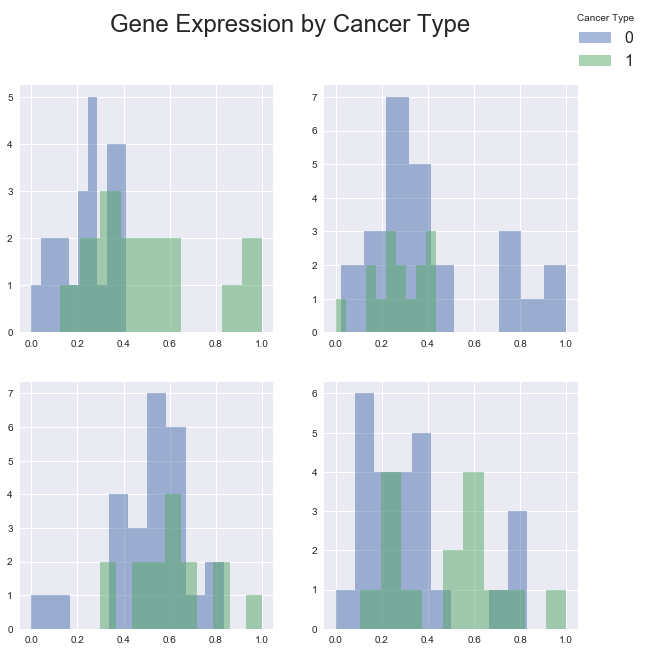

In [60]:
# Declare Plots
fig, axes = plt.subplots(2,2, figsize=(10,10))
labels= ["0", "1"]


axes[0,0].hist(cancer0['D29963_at'], alpha = 0.5, histtype='stepfilled', edgecolor='none')
axes[0,0].hist(cancer1['D29963_at'], alpha = 0.5, histtype='stepfilled', edgecolor='none')

axes[0,1].hist(cancer0['M23161_at'], alpha = 0.5, histtype='stepfilled', edgecolor='none')
axes[0,1].hist(cancer1['M23161_at'], alpha = 0.5, histtype='stepfilled', edgecolor='none')

axes[1,0].hist(cancer0['AFFX-PheX-5_at'], alpha = 0.5, histtype='stepfilled', edgecolor='none')
axes[1,0].hist(cancer1['AFFX-PheX-5_at'], alpha = 0.5, histtype='stepfilled', edgecolor='none')

axes[1,1].hist(cancer0['hum_alu_at'], alpha = 0.5, histtype='stepfilled', edgecolor='none')
axes[1,1].hist(cancer1['hum_alu_at'], alpha = 0.5, histtype='stepfilled', edgecolor='none')

fig.legend(labels, title="Cancer Type", fontsize=16)

fig.suptitle('Gene Expression by Cancer Type', fontsize=24);

----
Only one that is able to discriminate relatively well is `D29963_at` (top left).

----

**1.5:** Since our data has dimensions that are not easily visualizable, we want to reduce the dimensionality of the data to make it easier to visualize. Using PCA, find the top two principal components for the gene expression data. Generate a scatter plot using these principal components, highlighting the two cancer types in different colors. How well do the top two principal components discriminate between the two classes? How much of the variance within the data do these two principal components explain?

In [12]:
# Drop response again for PCA
x_train = x_train.drop(columns=['Cancer_type'])

In [13]:
# Fit PCA
pca = PCA(n_components=2)
comps = pca.fit_transform(x_train)

In [14]:
# Generate PCA DataFrame
pca_df = pd.DataFrame(data = comps,
                      columns = ['PC 1', 'PC 2'])
pca_df['Cancer_type'] = y_train.values

# Split by Type
cancer0_pca = pca_df[pca_df.Cancer_type == 0]
cancer1_pca = pca_df[pca_df.Cancer_type == 1]

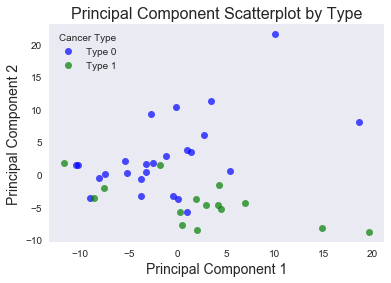

In [15]:
# Plot
plt.plot(cancer0_pca['PC 1'], cancer0_pca['PC 2'], 'bo', label='Type 0', alpha=.7)
plt.plot(cancer1_pca['PC 1'], cancer1_pca['PC 2'], 'go', label='Type 1', alpha=.7)

# Label
plt.title('Principal Component Scatterplot by Type', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=14)
plt.ylabel('Principal Component 2', fontsize=14)
plt.legend(title='Cancer Type', loc=2)
plt.grid(False)

plt.show()

In [16]:
# Report Explained Variance
print("PC1 contains {:f}% of the explained variance."
      .format(pca.explained_variance_ratio_[0]*100))
print("PC2 contains {:f}% of the explained variance."
      .format(pca.explained_variance_ratio_[1]*100))
print("Together, they contain {:f}% of the explained variance."
      .format(pca.explained_variance_ratio_[0]*100 + pca.explained_variance_ratio_[1]*100))

PC1 contains 15.889035% of the explained variance.
PC2 contains 11.428795% of the explained variance.
Together, they contain 27.317829% of the explained variance.


## Question 2: Linear Regression vs. Logistic Regression

In class we discussed how to use both linear regression and logistic regression for classification. For this question, you will work with a single gene predictor, `D29963_at`, to explore these two methods.

1. Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?

2. The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.

3. Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

4. Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

#### Answers: 

**2.1:** Fit a simple linear regression model to the training set using the single gene predictor `D29963_at`. We could interpret the scores predicted by the regression model interpreted for a patient as an estimate of the probability that the patient has `Cancer_type`=1. Is there a problem with this interpretation?


In [17]:
## Fit OLS Regression

# Isolate predictors
x_train_Dgene = x_train['D29963_at']
x_test_Dgene = x_test['D29963_at']

# Fit Model
gene_regression = sm.OLS(y_train, x_train_Dgene)
fit_sm = gene_regression.fit()

# Generate Predictions
pred_test = fit_sm.predict(x_test_Dgene)

# Report R Squared
print("Train R^2:", round(fit_sm.rsquared, 3))
print("Test  R^2:", round(r2_score(y_test, pred_test), 3))

Train R^2: 0.578
Test  R^2: 0.142


----
Linear regression is meant to be used for continuous numeric predictions. In this case, although the types of cancer are coded as 0 and 1, they are not really numeric; those are just the designations for two different _classes_ of cancer. Therefore, we should use a _classification_ model, not a regression model. The big drop in $R^2$ between the train and the test set shows that this is a poor model choice.

----


**2.2:** The fitted linear regression model can be converted to a classification model (i.e. a model that predicts one of two binary labels 0 or 1) by classifying patients with predicted score greater than 0.5 into `Cancer_type`=1, and the others into the `Cancer_type`=0. Evaluate the classification accuracy (1 - misclassification rate) of the obtained classification model on both the training and test sets.


In [18]:
# Classification Predictors
class_train = round(fit_sm.fittedvalues)
class_test = round(pred_test)

# Calculate error
error_train = np.mean(class_train.values != y_train.values)
error_test = np.mean(class_test.values != y_test.values)

# Report Rates
print("Classification Accuracy (Train):", 1-error_train)
print("Classification Accuracy  (Test):", round(1-error_test, 3))

Classification Accuracy (Train): 0.575
Classification Accuracy  (Test): 0.578


**2.3:** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to not regularize (use 'C=100000').

In [19]:
# Reshape Data
x_train_Dgene = x_train_Dgene.values.reshape(-1,1)
x_test_Dgene = x_test_Dgene.values.reshape(-1,1)

In [20]:
# Fit Logistic Regression
logit_class = LogisticRegression(C=100000)
logit_class.fit(x_train_Dgene, data_train['Cancer_type'])

# Get Classification Accuracy
acc_train = logit_class.score(x_train_Dgene, y_train)
acc_test = logit_class.score(x_test_Dgene, y_test)

# Report Accuracy
print("Logistic Classification Accuracy (Train):", round(acc_train, 3))
print("Logistic Classification Accuracy  (Test):", round(acc_test, 3))

Logistic Classification Accuracy (Train): 0.8
Logistic Classification Accuracy  (Test): 0.697


**2.4:** Plot the quantitative output from the linear regression model and the probabilistic output from the logistic regression model (on the training set points) as a function of the gene predictor. Also, display the true binary response for the training set points in the same plot. Based on these plots, does one of the models appear better suited for binary classification than the other? Explain.

In [21]:
pred_logit_train = logit_class.predict_proba(x_train_Dgene)[:,1]
pred_ols_train = fit_sm.predict(np.linspace(0, 1, 2))

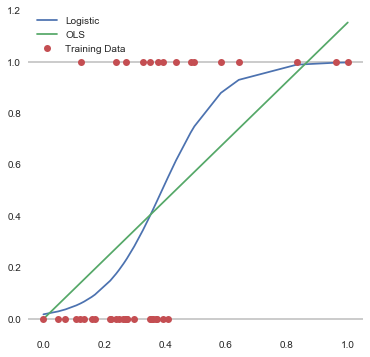

In [22]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.axhline(linewidth=2, color='black', alpha=0.2)
ax.axhline(y=1, linewidth=2, color='black', alpha=0.2)

ax.plot(sorted(x_train_Dgene), sorted(pred_logit_train), label='Logistic')
ax.plot(pred_ols_train, label='OLS')
ax.plot(x_train_Dgene, y_train, 'o', label='Training Data')

ax.set_facecolor('xkcd:white')
ax.grid(False)
ax.legend()

----------------
From these plots, it appears that the logistic model is better suited for binary classification than the linear model is. In the top-right corner of the plot, notice that the linear model can make predictions greater than 1. This makes it difficult to interpret the model as the probability of a point being 1 given X. Oppositely, the logistic model is bound by 0 and 1, making this interpretation more plausible.

----------------

## Question 3: Multiple Logistic Regression

1. Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

2. Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

In [23]:
#--------  visualize_prob
# A function to visualize the probabilities predicted by a Logistic Regression model
# Input: 
#      model (Logistic regression model)
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data: 0 or 1)
#      ax (an axis object to generate the plot)

def visualize_prob(model, x, y, ax):
    # Use the model to predict probabilities for
    y_pred = model.predict_proba(x)
    
    # Separate the predictions on the label 1 and label 0 points
    ypos = y_pred[y==1]
    yneg = y_pred[y==0]
    
    # Count the number of label 1 and label 0 points
    npos = ypos.shape[0]
    nneg = yneg.shape[0]
    
    # Plot the probabilities on a vertical line at x = 0, 
    # with the positive points in blue and negative points in red
    pos_handle = ax.plot(np.zeros((npos,1)), ypos[:,1], 'go', label = 'Cancer Type 1', alpha=0.5)
    neg_handle = ax.plot(np.zeros((nneg,1)), yneg[:,1], 'bo', label = 'Cancer Type 0', alpha=0.5)

    # Line to mark prob 0.5
    ax.axhline(y = 0.5, color = 'k', linestyle = '--')
    
    # Add y-label and legend, do not display x-axis, set y-axis limit
    ax.set_ylabel('Probability of AML class', fontsize=13)
    ax.legend(loc = 'best')
    ax.get_xaxis().set_visible(False)
    ax.set_ylim([-.1,1.1])

#### Answers 
**3.1:** Next, fit a multiple logistic regression model with all the gene predictors from the data set.  How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  

In [24]:
# Fit Multiple Logistic Regression
multi_log = LogisticRegression(C=100000)
multi_log.fit(x_train, data_train['Cancer_type'])

# Get Classification Accuracy
acc_train_mult = multi_log.score(x_train, y_train)
acc_test_mult = multi_log.score(x_test, y_test)

# Report Accuracy
print("Logistic Classification Accuracy (Train):", round(acc_train, 3))
print("Logistic Classification Accuracy  (Test):", round(acc_test, 3))
print("Multiple Logistic Classification Accuracy (Train):", round(acc_train_mult, 3))
print("Multiple Logistic Classification Accuracy  (Test):", round(acc_test_mult, 3))

Logistic Classification Accuracy (Train): 0.8
Logistic Classification Accuracy  (Test): 0.697
Multiple Logistic Classification Accuracy (Train): 1.0
Multiple Logistic Classification Accuracy  (Test): 0.97


----
The classification accuracies of the multiple logistic regression model are much higher than those of the single-variable logistic regression model. The train set has an accuracy of 1.0, which is unsurprising given the sheer number of predictors available. The test set also has a very high classification accuracy, which is good news for the ability of this model to make correct out of sample predictions.

----

**3.2:** Use the `visualize_prob` function provided below to visualize the probabilties predicted by the fitted multiple logistic regression model on both the training and test data sets. The function creates a visualization that places the data points on a vertical line based on the predicted probabilities, with the different cancer classes shown in different colors, and with the 0.5 threshold highlighted using a dotted horizontal line. Is there a difference in the spread of probabilities in the training and test plots? Are there data points for which the predicted probability is close to 0.5? If so, what can you say about these points?

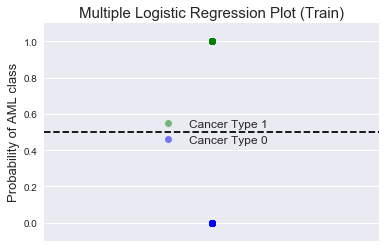

In [25]:
## Visualize Train Preds

# Declare Plot
fig, axis = plt.subplots(1,1)

# Plot Data
visualize_prob(multi_log, x_train, data_train['Cancer_type'], axis)

# Label
plt.title('Multiple Logistic Regression Plot (Train)', fontsize=15)
plt.legend(loc=10, fontsize=12)

plt.show()

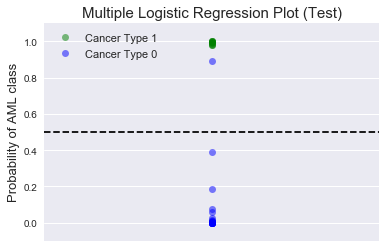

In [26]:
## Visualize Test Preds

# Declare Plot
fig, axis = plt.subplots(1,1)

# Plot Data
visualize_prob(multi_log, x_test, data_test['Cancer_type'], axis)

# Label
plt.title('Multiple Logistic Regression Plot (Test)', fontsize=15)
plt.legend(loc=2, fontsize=11)

plt.show()

----
The train predictions are all bunched at either 0 or 1, indicating that the model is very certain (correctly) of their classifications. The test predictions are more spread out, indicating the model is less certain of their classification, like the point close to 0.4. However, most of them are correctly classified. We see one misclassification with a value close to 0.9 that should actually be 0. Interestingly enough, if we moved our classification boundary upward, so that all values under 0.9 are classified as zeroes, the test model could also have a perfect classification rate.

----

## Question 4: Analyzing Significance of Coefficients

How many of the coefficients estimated by the multiple logistic regression in the previous problem are significantly different from zero at a *significance level of 95%*? 

Hint: To answer this question, use *bootstrapping* with 1000 boostrap samples/iterations.  

In [27]:
## accepts dataset inputs as numpy arrays
def make_bootstrap_sample(dataset_X, dataset_y, size = None):
    
    # by default return a bootstrap sample of the same size as the original dataset
    if not size: size = len(dataset_X)
    
    # Make sure indexes are standard
    dataset_X = dataset_X.reset_index()
    dataset_y = dataset_y.reset_index()
    del dataset_X['index']
    del dataset_y['index']
    
    # Start datasets
    bootstrap_dataset_X = dataset_X[0:0]
    bootstrap_dataset_y = dataset_y[0:0]
    
    # Generate Random Numbers
    random_indices = np.random.choice(size, size)
    
    # Add Rows to Bootstrap Sample
    bootstrap_dataset_X = dataset_X.loc[random_indices]
    bootstrap_dataset_y = dataset_y.loc[random_indices]
    
    # if the X and y datasets aren't the same size, raise an exception
    if len(dataset_X) != len(dataset_y):
        raise Exception("Data size must match between dataset_X and dataset_y")
    
    return (bootstrap_dataset_X, bootstrap_dataset_y)
    

def calculate_coefficients(dataset_X, dataset_y, model):
    
    model = model.fit(dataset_X, dataset_y)
    
    coefficients_dictionary = dict()
    
    for i, col in enumerate(dataset_X.columns):
        coefficients_dictionary[col] = model.coef_.ravel()[i]

    return coefficients_dictionary


def get_significant_predictors(regression_coefficients, p = 0.05):
    
    significant_coefficients = []
    
    # make dataframe of coefficients
    coeffs_df = pd.DataFrame(regression_coefficients)
    
    # for every feature in the dataframe
    for col in coeffs_df.columns:
        
        if (coeffs_df[col].quantile(p/2) > 0 or 
            coeffs_df[col].quantile(1-(p/2)) < 0):
            
            significant_coefficients.append(col)
            
    # return the significant coefficients as a list of strings
    return significant_coefficients

In [28]:
# List of Dicts w/ Coefficients
c_dict = []

# For 1000 iterations
for n in range(1000):
    
    # Make Samples
    x, y = make_bootstrap_sample(x_train, y_train)
    
    # Calculate Coefficients
    c_dict.append(calculate_coefficients(x, y.values.ravel(), multi_log))

In [29]:
# Find Significant Predictors
log_significant_bootstrap = get_significant_predictors(c_dict, p = 0.05)
print('Significant Predictors: ', len(log_significant_bootstrap))

Significant Predictors:  1865


#### Answer: At the 95% significance level, using 1,000 bootstrap samples, we find that 1,865 of the 7,129 predictors are significant.

## Question 5: High Dimensionality

One of the issues you may run into when dealing with high dimensional data is that your 2D and 3D intuition may fail breakdown. For example, distance metrics in high dimensions can have properties that may feel counterintuitive.

Consider the following: You have a hypersphere with a radius of $1$, inside of a hypercube centered at $0$, with edges of length $2$.

1. As a function of $d$, the number of dimensions, how much of the hypercube's volume is contained within the hypersphere?
2. What happens as $d$ gets very large?
3. Using the functions provided below, create a plot of how the volume ratio changes as a function of $d$.
4. What does this tell you about where the majority of the volume of the hypercube resides in higher dimensions? 

*HINTS:* 
- The volume of a hypercube with edges of length $2$ is $V_c(d) = 2^d$.
- The volume of a hyperphere with a radius of $1$ is $V_s(d) = \frac{\pi^{\frac{d}{2}}} {\Gamma(\frac{d}{2}+1)}$, where $\Gamma$ is Euler's Gamma Function.
- $\Gamma$ is increasing for all $d \geq 1$.

In [30]:
def V_c(d):
    """
    Calculate the volume of a hypercube of dimension d.
    """
    return 2**d

def V_s(d):
    """
    Calculate the volume of a hypersphere of dimension d.
    """
    return math.pi**(d/2)/gamma((d/2)+1)

#### Answers:

#### 5.1
Since the hypersphere is always entirely contained _within_ the hypercube, the ratio of the volume of the hypercube within the hypersphere and the total volume of the hypercube is equal to the ratio of the hypersphere's volume to the hypercube's volume. As d increases, this ratio approaches zero. (See function below.)

In [31]:
def V_ratio(d):
    
    """
    Calculate the percentage of a hypercube's volume within
    a hypersphere of the same dimension d.
    """
    
    return V_s(d) / V_c(d)

#### 5.2
As d increases, the volume ratio goes to zero, meaning the hypercube's volume is much higher than the hypersphere's at higher dimensions.

In [32]:
## See how ratio changes in dimensions we understand

# 2D
print("Circle Area:", round(V_s(2), 2))
print("Square Area:", V_c(2))

# 3D
print("\nSphere Vol:", round(V_s(3), 2))
print("Cube   Vol:", V_c(3))

# Change from 2D to 3D
print("\n2D Ratio:", round(V_s(2)/V_c(2), 3))
print("3D Ratio:", round(V_s(3)/V_c(3), 3))

Circle Area: 3.14
Square Area: 4

Sphere Vol: 4.19
Cube   Vol: 8

2D Ratio: 0.785
3D Ratio: 0.524


In [35]:
# See how ratio changes as d increases past dimensions we can understand
ratios = []
for d in range(3, 15):
    ratios.append(V_ratio(d))
    dim
    print(round(V_ratio(d), 4))

0.5236
0.3084
0.1645
0.0807
0.0369
0.0159
0.0064
0.0025
0.0009
0.0003
0.0001
0.0


#### 5.3

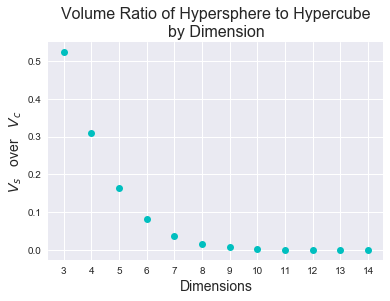

In [36]:
## Visualize Ratio Change

# Plot
dim = range(3, 15, 1)
plt.plot(dim, ratios, 'co')

# Label
plt.title('Volume Ratio of Hypersphere to Hypercube\nby Dimension', fontsize=16)
plt.xlabel('Dimensions', fontsize=14)
plt.ylabel('$V_s$   over   $V_c$', fontsize=14)
plt.xticks(range(3, 15, 1))

plt.show()

#### 5.4

The fact that the volume of a hypercube contained within a hypersphere decreases as the dimension increases tells us that, in higher dimensions, most of a hypercube's volume resides in the "corners", or the higher-dimension equivalent of corners that lie outside the hypersphere.

## Question 6: PCA and Dimensionality Reduction

As we saw above, high dimensional problems can have counterintuitive behavior, thus we often want to try to reduce the dimensionality of our problems. A reasonable approach to reduce the dimensionality of the data is to use PCA and fit a logistic regression model on the smallest set of principal components that explain at least 90% of the variance in the predictors.

1. Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

2. Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

#### Answers:

**6.1:** Using the gene data from Problem 1, how many principal components do we need to capture at least 90% of the variance? How much of the variance do they actually capture? Fit a Logistic Regression model using these principal components. How do the classification accuracy values on both the training and tests sets compare with the models fit in question 3.1?  

In [37]:
# Find components to reach 90% explained variance

# For each additional component
for comp in range(len(data_train)):

    # Fit PCA
    pca = PCA(n_components=comp)
    pca.fit(x_train)
    
    # Get total sum of explained variance
    variance = sum(pca.explained_variance_ratio_)
    
    # Stop when we get to 90%
    if variance > 0.9:
        break
        
print("Components:", comp)
print("Explained Variance:", round(variance, 3))

Components: 29
Explained Variance: 0.903


In [38]:
# Transform predictors to Principal Components
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)

# Fit Logistic Regression on Principal Components
pca_reg = LogisticRegression(C=100000)
pca_reg.fit(pca_train, data_train['Cancer_type'])

# Get Classification Accuracy
acc_train_pca = pca_reg.score(pca_train, y_train)
acc_test_pca = pca_reg.score(pca_test, y_test)

# Report Accuracy
print("Logistic Classification Accuracy (Train):", round(acc_train, 3))
print("Logistic Classification Accuracy  (Test):", round(acc_test, 3))
print("\nMultiple Logistic Classification Accuracy (Train):", round(acc_train_mult, 3))
print("Multiple Logistic Classification Accuracy  (Test):", round(acc_test_mult, 3))
print("\nPCA Logistic Classification Accuracy (Train):", round(acc_train_pca, 3))
print("PCA Logistic Classification Accuracy  (Test):", round(acc_test_pca, 3))

Logistic Classification Accuracy (Train): 0.8
Logistic Classification Accuracy  (Test): 0.697

Multiple Logistic Classification Accuracy (Train): 1.0
Multiple Logistic Classification Accuracy  (Test): 0.97

PCA Logistic Classification Accuracy (Train): 1.0
PCA Logistic Classification Accuracy  (Test): 0.818


----
Our model fit on 29 PCA components has a perfect classification rate for the train set, just like the Multiple Logistic Regression model. However, the accuracy of the test set drops from 0.97 to 0.82

----

**6.2:** Use the code provided in question 3 to visualize the probabilities predicted by the fitted model on both the training and test sets. How does the spread of probabilities in these plots compare to those for the model in question 3.2? If the lower dimensional representation yields comparable predictive power, what advantage does the lower dimensional representation provide?

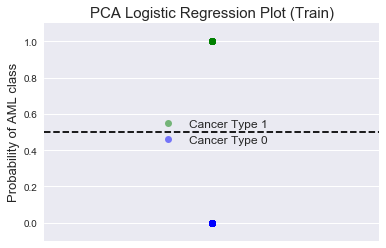

In [39]:
## Visualize PCA Train Preds

# Declare Plot
fig, axis = plt.subplots(1,1)

# Plot Data
visualize_prob(pca_reg, pca_train, data_train['Cancer_type'], axis)

# Label
plt.title('PCA Logistic Regression Plot (Train)', fontsize=15)
plt.legend(loc=10, fontsize=12)

plt.show()

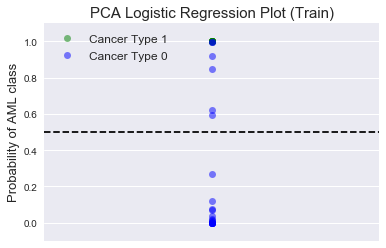

In [40]:
## Visualize Test Preds

# Declare Plot
fig, axis = plt.subplots(1,1)

# Plot Data
visualize_prob(pca_reg, pca_test, data_test['Cancer_type'], axis)

# Label
plt.title('PCA Logistic Regression Plot (Train)', fontsize=15)
plt.legend(loc=2, fontsize=12)

plt.show()

----
The PCA and Multiple Logistic Regression training plots are comparable: values correctly bunched at 0 and 1. However, the PCA test plot shows a higher spread than the MLR test plot; all test values of Cancer Type 1 are correctly bunched around 1, but the model gives several cases of Type 0 a high probability of being Type 1, where the MLR misclassified only one observation.

Advantages of lower dimenstionality inclues lower risk of overfitting and lower computational requirements.

----


## Multiclass Thyroid Classification

In this problem, you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw5_2.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was obtained from the UCI Machine Learning Repository.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore the use of different methods for multiclass classification.

First task: split the data using the code provided below.

## Question 7: Fit Classification Models

1. Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?

2. Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).

3. Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

4. Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors
 <br>
*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 

5. Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 


*Hint:* You may use the `KNeighborsClassifier` class to fit a k-NN classification model.

#### Answers:

**7.0:** First task: split the data using the code provided below. 

In [41]:
np.random.seed(9001)
df = pd.read_csv('data/dataset_hw5_2.csv')
msk = np.random.rand(len(df)) < 0.5
data_train = df[msk]
data_test = df[~msk]

In [42]:
print("Split is {} train observations and {} test observations."
     .format(len(data_train), len(data_test)))

Split is 102 train observations and 113 test observations.


**7.1:** Generate a 2D scatter plot of the training set, denoting each class with a different color. Does it appear that the data points can be separated well by a linear classifier?


In [43]:
# View Dataframe
data_train.head()

,Biomarker 1,Biomarker 2,Diagnosis
0,0.262372,0.875473,1.0
5,0.336479,1.098616,1.0
9,0.182330,-1.609488,2.0
12,-0.223131,0.788462,1.0
13,0.587792,1.458617,1.0


In [44]:
# Separate Data by Classes
class1 = data_train[data_train.Diagnosis == 1]
class2 = data_train[data_train.Diagnosis == 2]
class3 = data_train[data_train.Diagnosis == 3]

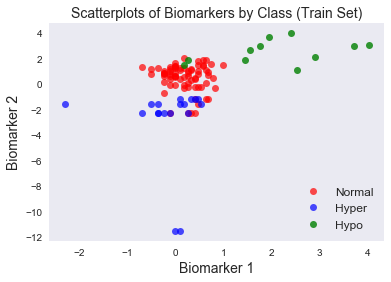

In [45]:
# Scatter Plot
plt.plot(class1['Biomarker 1'], class1['Biomarker 2'],
         'ro', alpha=.7, label='Normal')
plt.plot(class2['Biomarker 1'], class2['Biomarker 2'],
         'bo', alpha=.7, label='Hyper')
plt.plot(class3['Biomarker 1'], class3['Biomarker 2'],
         'go', alpha=.8, label='Hypo')

# Label
plt.title('Scatterplots of Biomarkers by Class (Train Set)', fontsize=14)
plt.xlabel('Biomarker 1', fontsize=14)
plt.ylabel('Biomarker 2', fontsize=14)
plt.grid(False)
plt.legend(fontsize=12, loc=4)

plt.show()

----
It does seem like this would be a good problem for linear classifiers. The three classes seem to be easily distinguishable in well-defined clusters except for a few cases.

----

**7.2:** Briefly explain the difference between multinomial logistic regression and one-vs-rest (OvR) logistic regression methods for fitting a multiclass classifier (in 2-3 sentences).


----
OvR logistic regression assumes that for each class, there is an independent classification problem. For each class, it tries to find the major distinctions between that class and the combination of all of the others. Multinomial logistic regression, on the other hand, attempts to fit a model using only only one class as a reference group.

----

**7.3:** Fit linear classification models on the thyroid data set using both the methods.  You should use $L_2$ regularization in both cases, tuning the regularization parameter using cross-validation.  Is there a difference in the overall classification accuracy of the two methods on the test set?

In [46]:
# Separate Predictors and Response
y_train = data_train['Diagnosis']
y_test = data_test['Diagnosis']

x_train = data_train.drop(columns='Diagnosis')
x_test = data_test.drop(columns='Diagnosis')

In [47]:
x_train.head()

,Biomarker 1,Biomarker 2
0,0.262372,0.875473
5,0.336479,1.098616
9,0.182330,-1.609488
12,-0.223131,0.788462
13,0.587792,1.458617


In [48]:
y_train.head()

0     1.0
5     1.0
9     2.0
12    1.0
13    1.0
Name: Diagnosis, dtype: float64

In [49]:
## Multinomial Logistic Regression

# Fit Model
mult_reg = LogisticRegressionCV(multi_class='multinomial', penalty='l2', cv=5)
mult_reg.fit(x_train, y_train.values.ravel())

# Get Classification Accuracy
acc_train_mlr = mult_reg.score(x_train, y_train.values.ravel())
acc_test_mlr = mult_reg.score(x_test, y_test.values.ravel())

# Report Accuracy
print("Multinomial Classification Accuracy (Train):", round(acc_train_mlr, 3))
print("Multinomial Classification Accuracy  (Test):", round(acc_test_mlr, 3))

Multinomial Classification Accuracy (Train): 0.892
Multinomial Classification Accuracy  (Test): 0.885


In [50]:
## One-vs-Rest Logistic Regression

# Fit Model
ovr_reg = LogisticRegressionCV(multi_class='ovr', penalty='l2', cv=5)
ovr_reg.fit(x_train, y_train.values.ravel())

# Get Classification Accuracy
acc_train_ovr = ovr_reg.score(x_train, y_train.values.ravel())
acc_test_ovr = ovr_reg.score(x_test, y_test.values.ravel())

# Report Accuracy
print("One-vs-Rest Classification Accuracy (Train):", round(acc_train_ovr, 3))
print("One-vs-Rest Classification Accuracy  (Test):", round(acc_test_ovr, 3))

One-vs-Rest Classification Accuracy (Train): 0.863
One-vs-Rest Classification Accuracy  (Test): 0.867


----
The One-vs-Rest model is slightly less accurate than the Multinomial model is at predicting the test set.

----

**7.4:** Also, compare the training and test accuracies of these models with the following classification methods:
    - Multiclass Logistic Regression with quadratic terms 
    - Linear Discriminant Analysis
    - Quadratic Discriminant Analysis
    - k-Nearest Neighbors

*Note:* you may use either the OvR or multinomial variant for the multiclass logistic regression (with $L_2$ regularization). Do not forget to use cross-validation to choose the regularization parameter, and also the number of neighbors in k-NN. 


In [51]:
def get_poly_dataset(df, n=2):
        
    poly = PolynomialFeatures(n,include_bias = False)
    design_df = poly.fit_transform(df)
        
    return design_df

In [52]:
## Multinomial Logistic Regression

# Get Quadratic Terms
x_poly_train = get_poly_dataset(x_train)
x_poly_test = get_poly_dataset(x_test)

# Fit Model
mult_poly_reg = LogisticRegressionCV(multi_class='multinomial', penalty='l2', cv=5)
mult_poly_reg.fit(x_poly_train, y_train)

# Get Classification Accuracy
mult_train_score = mult_poly_reg.score(x_poly_train, y_train.values.ravel())
mult_test_score = mult_poly_reg.score(x_poly_test, y_test.values.ravel())

# Report Accuracy
print("Multinomial Classification Accuracy (Poly-Train):", round(mult_train_score, 3))
print("Multinomial Classification Accuracy  (Poly-Test):", round(mult_test_score, 3))

Multinomial Classification Accuracy (Poly-Train): 0.892
Multinomial Classification Accuracy  (Poly-Test): 0.903


In [53]:
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

fitted_lda = LinearDiscriminantAnalysis().fit(x_train, y_train)
fitted_qda = QuadraticDiscriminantAnalysis().fit(x_train, y_train)

lda_train_score = fitted_lda.score(x_train, y_train)
qda_train_score = fitted_qda.score(x_train, y_train)

lda_test_score = fitted_lda.score(x_test, y_test)
qda_test_score = fitted_qda.score(x_test, y_test)

print('LDA Training Set Score:', round(lda_train_score,3))
print('QDA Training Set Score:', round(qda_train_score,3))
print()

print('LDA Test Set Score:', round(lda_test_score,3))
print('QDA Test Set Score:', round(qda_test_score,3))

LDA Training Set Score: 0.873
QDA Training Set Score: 0.873

LDA Test Set Score: 0.832
QDA Test Set Score: 0.85


In [54]:
# declare and pass a KFold object to properly shuffle the training data, and/or set the random state
splitter = KFold(5, random_state=42, shuffle=True)

neighbors = [1, 2, 3, 4, 5, 7, 10, 15]

# List of Validation Scores
avg_knn_scores = [0] * len(neighbors)

for i, n in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors = n)
    avg_knn_scores[i] = np.mean(cross_val_score(knn, x_train, y_train, cv=splitter))

best_n = neighbors[np.argmax(avg_knn_scores)]
    
print('By cross validation, we should use', best_n, 'nieghbors to classify the data')

knn = KNeighborsClassifier(n_neighbors = best_n)
fitted_knn = knn.fit(x_train, y_train)

knn_train_score = fitted_knn.score(x_train, y_train)
knn_test_score = fitted_knn.score(x_test, y_test)

print('3-NN Training Set Score:', round(knn_train_score,3))
print('3-NN Test Set Score:', round(knn_test_score,3))


By cross validation, we should use 3 nieghbors to classify the data
3-NN Training Set Score: 0.931
3-NN Test Set Score: 0.867


In [55]:
# Compare

# Multinomial Logistic Regression
print("Multinomial Classification Accuracy (Train):", round(acc_train_mlr, 3))
print("Multinomial Classification Accuracy  (Test):", round(acc_test_mlr, 3))
print()
# OvR Logistic Regresion
print("One-vs-Rest Classification Accuracy (Train):", round(acc_train_ovr, 3))
print("One-vs-Rest Classification Accuracy  (Test):", round(acc_test_ovr, 3))
print()
# Multinomial Logistic Regression on Polynomial Data Sets
print("Multinomial Classification Accuracy (Poly-Train):", round(mult_train_score, 3))
print("Multinomial Classification Accuracy  (Poly-Test):", round(mult_test_score, 3))
print()
# LDA
print('LDA Training Set Score:', round(lda_train_score,3))
print('LDA Test Set Score:', round(lda_test_score,3))
print()
# QDA
print('QDA Training Set Score:', round(qda_train_score,3))
print('QDA Test Set Score:', round(qda_test_score,3))
print()
# KNN (3-Neighbors)
print('3-NN Training Set Score:', round(knn_train_score,3))
print('3-NN Test Set Score:', round(knn_test_score,3))

Multinomial Classification Accuracy (Train): 0.892
Multinomial Classification Accuracy  (Test): 0.885

One-vs-Rest Classification Accuracy (Train): 0.863
One-vs-Rest Classification Accuracy  (Test): 0.867

Multinomial Classification Accuracy (Poly-Train): 0.892
Multinomial Classification Accuracy  (Poly-Test): 0.903

LDA Training Set Score: 0.873
LDA Test Set Score: 0.832

QDA Training Set Score: 0.873
QDA Test Set Score: 0.85

3-NN Training Set Score: 0.931
3-NN Test Set Score: 0.867


**7.5:** Does the inclusion of the polynomial terms in logistic regression yield better test accuracy compared to the model with only linear terms? 

----
Unsurprinsgly, the inclusion of polynomial terms in logistic regression yields a better test accuracy compared to the model with only linear terms.

----

## Question 8: Visualize Decision Boundaries

The following code will allow you to visualize the decision boundaries of a given classification model.

In [56]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      model (the classifier you want to visualize)
#      title (title for plot)
#      ax (a set of axes to plot on)
#      poly_degree (highest degree of polynomial terms included in the model; None by default)

def plot_decision_boundary(x, y, model, title, ax, poly_degree=None):
    # Create mesh
    # Interval of points for biomarker 1
    min0 = x[:,0].min()
    max0 = x[:,0].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for biomarker 2
    min1 = x[:,1].min()
    max1 = x[:,1].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh of points
    # Check if polynomial terms need to be included
    if(poly_degree!=None):
        # Use PolynomialFeatures to generate polynomial terms
        poly = PolynomialFeatures(poly_degree,include_bias = False)
        xx_ = poly.fit_transform(xx)
        yy = model.predict(xx_) 
        
    else:   
        yy = model.predict(xx)
        
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    ax.contourf(x1, x2, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot scatter plot of data
    yy = y.reshape(-1,)
    ax.scatter(x[yy==1,0], x[yy==1,1], c='blue', label='Normal', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==2,0], x[yy==2,1], c='cyan', label='Hyper', cmap=plt.cm.coolwarm)
    ax.scatter(x[yy==3,0], x[yy==3,1], c='red', label='Hypo', cmap=plt.cm.coolwarm)
    
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel('Biomarker 1')
    ax.set_ylabel('Biomarker 2')

**Note:** The provided code uses `sklearn`'s `PolynomialFeatures` to generate higher-order polynomial terms, with degree `poly_degree`. 
Also, if you have loaded the data sets into `pandas` data frames, you may use the `as_matrix` function to obtain a `numpy` array from the data frame objects.

1. Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.
2. Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.
3. QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

#### Answers:

**8.1:** Use the above code to visualize the decision boundaries for each of the model fitted in the previous question.

Z:\Users\Erik\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


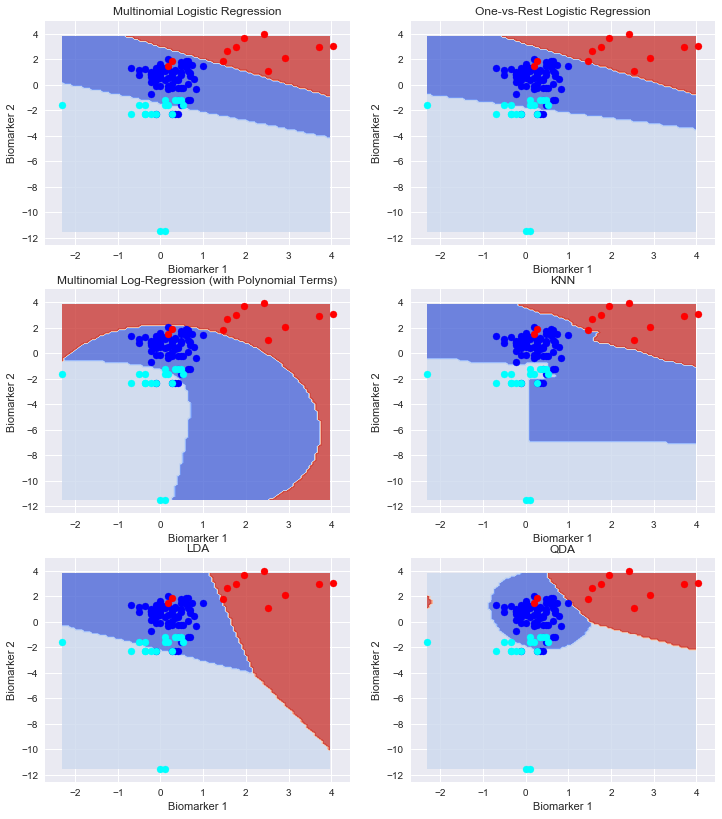

In [57]:
x = data_train.drop(columns='Diagnosis').as_matrix()
y = data_train['Diagnosis'].values.ravel()

fig, axes = plt.subplots(3, 2, figsize=(12,14))

plot_decision_boundary(x, y, mult_reg, 'Multinomial Logistic Regression', axes[0,0])
plot_decision_boundary(x, y, ovr_reg, 'One-vs-Rest Logistic Regression', axes[0,1])
plot_decision_boundary(x, y, mult_poly_reg, 'Multinomial Log-Regression (with Polynomial Terms)', axes[1,0], poly_degree=2)
plot_decision_boundary(x, y, fitted_knn, 'KNN', axes[1,1])
plot_decision_boundary(x, y, fitted_lda, 'LDA', axes[2,0])
plot_decision_boundary(x, y, fitted_qda, 'QDA', axes[2,1])

**8.2:** Comment on the difference in the decision boundaries (if any) for the OvR and multinomial logistic regression models. Is there a difference between the decision boundaries for the linear logistic regression models and LDA. What about the decision boundaries for the quadratic logistic regression and QDA? Give an explanation for your answer.

---
The multinomial and OvR logistic regression models are nearly identical, though the multinomial model classifies a few more points correctly than the OvR one does, particularly among the Class 2 (Hyperthyroidism) points. 

There is a fairly significant difference in the decision boundaries of the LDA and linear logistic regression models. Instead of using two distinct lines to separate the points in to three zones, the LDA model uses a single line that splits into two branches. Though, while LDA looks more powerful than the logistic regression models do, it turns out to be less accurate than them in predicting both the training set and the test set.


The quadratic logistic regression model (QLM) is vastly different from the QDA one. The QLM model grants much more area to Classes 1 and 2 than the QDA one does, and it correctly classifies more points in Class 3 than QDA does. Though, just by visualizing the two classification models, the QDA one feels far more intuitive than the QLM one does. This is partly because much of the area under Class 2 (blue) is far closer to a Class 3 point (cyan) than it is to a Class 2 point.

---

**8.3:** QDA is a generalization of the LDA model. What's the primary difference that makes QDA more general? How does that manifest in the plots you generated?

---
Unlike LDA, QDA relaxes the assumption that the variances of each class are equal. This allows us to get quadratic boundaries, like the one that surrounds the blue points in the QDA model, rather than linear ones.

---